## Exploratory Data Analysis

In this notebook, I will analyse and showcase the dataset based on the following criteria:

**1. Overall Hours Analysis:**
Examine the total hours quoted vs. the actual hours worked, including overtime.

**2. Director Impact Analysis:**
Investigate whether the director in charge influences project hours or shows any trends.

**3. Correlation with House Prices:**
Explore the relationship between the house price and the hours quoted/overworked. Assess whether higher house values correlate with more hours quoted, under the hypothesis that homeowners with higher-value properties might invest more in their projects.

By the end of this analysis, I aim to uncover actionable insights that can inform a prediction model to help the firm improve its project quoting accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.functions import postcode_anonymisation, director_anonymisation

#### Data Dictionary
| Variable          | Definition                                           |
|-------------------|------------------------------------------------------|
| Project No        | Project number on file                               |
| Project Address   | Project address                                      |
| Postcode          | Project postcode                                     |
| Director          | Director in charge                                   |
| Stage 1           | Hours quoted for Stage 1 (Preparation and Briefing)  |
| Stage 2           | Hours quoted for Stage 2 (Concept Design)            |
| Stage 3           | Hours quoted for Stage 3 (Spatial Coordination)      |
| Stage 4           | Hours quoted for Stage 4 (Technical Design)          |
| Stage 1 OT        | Overtime hours worked during Stage 1                 |
| Stage 2 OT        | Overtime hours worked during Stage 2                 |
| Stage 3 OT	    | Overtime hours worked during Stage 3                 |
| Stage 4 OT	    | Overtime hours worked during Stage 4                 |
| Current Est Value | Current estimated property value as of June 2024     |

In [2]:
df = pd.read_csv("Projects - Quote Data.csv")

In [3]:
# Omitting and anonymising certain columns to protect personal data
df.drop("Project Address", axis=1, inplace=True)
postcode_anonymisation(df, "Postcode")
director_anonymisation(df, "Director")
df.head()

,Project No,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value
0,2124,W4 ***,B,4,14,8.0,28.0,1.0,13.5,5.70,5.20,"£1,065,733"
1,2129,SW17 ***,A,12,1,5.0,NaN,2.8,0.0,2.60,NaN,"£510,554"
2,2133,SW16 ***,A,13,10,6.0,26.0,7.0,24.0,19.00,0.00,"£747,169"
3,2136,SW11 ***,B,12,11,5.0,14.0,9.3,-2.0,12.17,18.90,"£1,520,156"
4,2146,SW17 ***,A,12,14,7.0,35.0,-1.2,-4.7,-0.80,-1.89,"£658,430"


In [4]:
# Overview of information contained in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Project No         50 non-null     int64  
 1   Postcode           50 non-null     object 
 2   Director           50 non-null     object 
 3   Stage 1            50 non-null     int64  
 4   Stage 2            50 non-null     int64  
 5   Stage 3            48 non-null     float64
 6   Stage 4            44 non-null     float64
 7   Stage 1 OT         49 non-null     float64
 8   Stage 2 OT         46 non-null     float64
 9   Stage 3 OT         43 non-null     float64
 10  Stage 4 OT         43 non-null     float64
 11  Current Est Value  50 non-null     object 
dtypes: float64(6), int64(3), object(3)
memory usage: 4.8+ KB


In [5]:
# Looking at missing values
df.isnull().sum()

Project No           0
Postcode             0
Director             0
Stage 1              0
Stage 2              0
Stage 3              2
Stage 4              6
Stage 1 OT           1
Stage 2 OT           4
Stage 3 OT           7
Stage 4 OT           7
Current Est Value    0
dtype: int64

It's worth mentioning that there are true missing values in this dataset, but also missing values on purpose. There are entries "N/A" indicating "Not Applicable", and have been converted into NaN values when the csv is imported. This usually occurs when a certain stage wasn't quoted for a project, for example, a client could request a quote for Stages 1 and 2 only.

The true missing values in this dataset are mostly found under the overtime columns. These missing data are a result of human factor - due to poor timesheet recording practices by the employees / directors. I will need to consider these missing values after the EDA in the next stage when modelling.

The "N/A" entries are not true missing values and should be treated differently.

### 1. Overall Hours Analysis

In [6]:
# Creating 3 new columns to look at total hours
df["Total Quoted"] = df.iloc[:, 3:7].sum(axis=1, skipna=True)
df["Total OT"] = df.iloc[:, 7:11].sum(axis=1, skipna=True)
df["Total Hours"] = df.iloc[:, 12:14].sum(axis=1, skipna=True)
df.head()

,Project No,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value,Total Quoted,Total OT,Total Hours
0,2124,W4 ***,B,4,14,8.0,28.0,1.0,13.5,5.70,5.20,"£1,065,733",54.0,25.40,79.40
1,2129,SW17 ***,A,12,1,5.0,NaN,2.8,0.0,2.60,NaN,"£510,554",18.0,5.40,23.40
2,2133,SW16 ***,A,13,10,6.0,26.0,7.0,24.0,19.00,0.00,"£747,169",55.0,50.00,105.00
3,2136,SW11 ***,B,12,11,5.0,14.0,9.3,-2.0,12.17,18.90,"£1,520,156",42.0,38.37,80.37
4,2146,SW17 ***,A,12,14,7.0,35.0,-1.2,-4.7,-0.80,-1.89,"£658,430",68.0,-8.59,59.41


In [7]:
# I'd like to create a smaller dataframe looking at overall numbers based on the RIBA Stages
hours_quoted = df.iloc[:, 3:7].sum(axis=0)
hours_quoted

Stage 1     572.0
Stage 2     714.0
Stage 3     277.0
Stage 4    1349.0
dtype: float64

In [8]:
# Getting a column name for a new dataframe
stages = hours_quoted.index.tolist()
stages

['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']

In [9]:
hours_quoted = hours_quoted.tolist()
hours_quoted

[572.0, 714.0, 277.0, 1349.0]

In [10]:
hours_ot = df.iloc[:, 7:11].sum(skipna=True,axis=0).round(2).tolist()
hours_ot

[317.84, 359.0, 137.32, 122.83]

In [11]:
total_hours = []
for i in range(len(hours_ot)):
    sum = hours_quoted[i] + hours_ot[i]
    total_hours.append(sum)

total_hours

[889.8399999999999, 1073.0, 414.32, 1471.83]

In [12]:
df_hours = pd.DataFrame({
    "Stages": stages,
    "Quoted Hours": hours_quoted,
    "Overtime Hours": hours_ot,
    "Total Hours": total_hours
})

df_hours

,Stages,Quoted Hours,Overtime Hours,Total Hours
0,Stage 1,572.0,317.84,889.84
1,Stage 2,714.0,359.00,1073.00
2,Stage 3,277.0,137.32,414.32
3,Stage 4,1349.0,122.83,1471.83


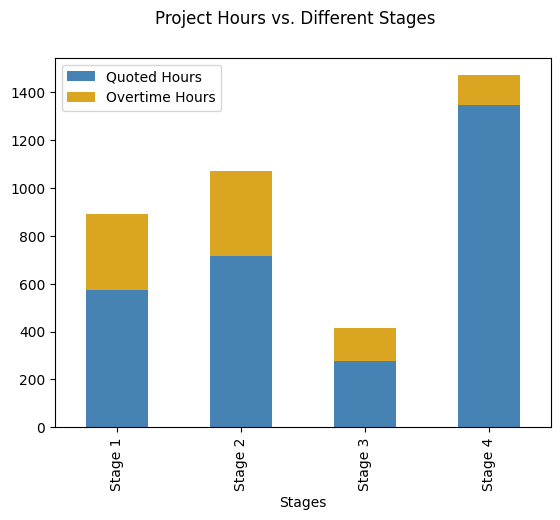

In [13]:
df_hours.plot(x="Stages", y=["Quoted Hours", "Overtime Hours"], kind="bar", stacked=True, color=["steelblue", "goldenrod"])
plt.suptitle("Project Hours vs. Different Stages")
plt.show()

In [14]:
# Looking at the amount of overtime occurs per stage
df_hours["Overtime %"] = round((df_hours["Overtime Hours"] / df_hours["Quoted Hours"]) * 100, 2)
df_hours

,Stages,Quoted Hours,Overtime Hours,Total Hours,Overtime %
0,Stage 1,572.0,317.84,889.84,55.57
1,Stage 2,714.0,359.00,1073.00,50.28
2,Stage 3,277.0,137.32,414.32,49.57
3,Stage 4,1349.0,122.83,1471.83,9.11


Stages 1 is the most under-quoted stage, 2 and 3 are majorly underquoted, being around 50% of the quoted hours, meaning the actual time spent is around 150% of what's quoted.

**This shows that the stage matters and will be considered as a feature when building a model.**

### 2. Director Impact Analysis

In [15]:
# Looking at the amount of projects for each director
df.value_counts("Director").sort_index(ascending=True)

Director
A    24
B    26
Name: count, dtype: int64

The dataset is fairly even, consisting of 24 projects with director A and 26 with director B.

In [16]:
# Looking at missing values for each director
df.groupby("Director").apply(lambda x: x.isnull().sum())

/var/folders/gg/zy9sr5191bg1yg8gbtj9w1k80000gp/T/ipykernel_13539/3509046569.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("Director").apply(lambda x: x.isnull().sum())


,Project No,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value,Total Quoted,Total OT,Total Hours
Director,,,,,,,,,,,,,,,
A,0,0,0,0,0,0,1,1,4,4,1,0,0,0,0
B,0,0,0,0,0,2,5,0,0,3,6,0,0,0,0


As previously mentioned, the two missing values under Stage 3 and Stage 4 for director B are not true missing values, these represents projects that did not wish to have a quote for these stages. It is then clear to see that after taking these 7 entries out, Director A has more true missing values.

**This showcases that Director A has more projects with timesheet recording issues.**

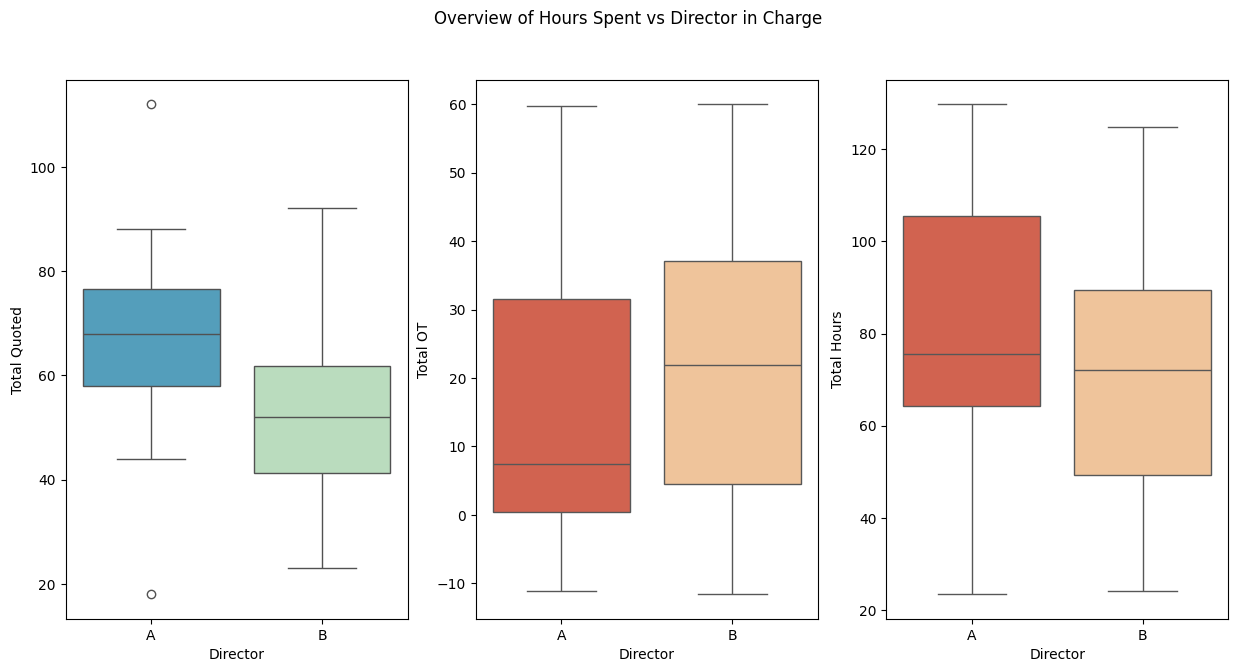

In [17]:
# Looking at hours and the director in charge
fig, ax = plt.subplots(1,3, figsize=(15,7))

sns.boxplot(data=df, x="Director", y="Total Quoted", order=["A", "B"],
            hue="Director", palette="GnBu", ax = ax[0])
sns.boxplot(data=df, x="Director", y="Total OT", order=["A", "B"],
            hue="Director", palette="OrRd", ax = ax[1])
sns.boxplot(data=df, x="Director", y="Total Hours", order=["A", "B"],
            hue="Director", palette="OrRd", ax = ax[2])

plt.suptitle("Overview of Hours Spent vs Director in Charge")
plt.show()

In the first plot, we observe that Director A generally quotes for more hours overall compared to Director B. A has an overall higher median and a much higher interquartile range. The boxplot shows that there are a couple of outliers at either end.

In the middle plot, more overtime on projects for Director B occurs. Although the difference between the interquartile range for the two directors is not as significant as the left plot, the median for total overtime hours worked for Director B's projects is notably higher than Director A's ones.

The last plot shows the total hours the projects ended up taking. It looks like the median is very close for A and B, as well as the extent of the whiskers. However, the interquartile range for Director A is higher despite other measures are fairly similar.

**Overall, it seems like Director A tends to quote for more hours, therefore the director should be considered as a feature for the model.**

The fact that Director A quotes for more hours could be because of they tend to take on bigger projects, or just that they are simply better than Director B at quoting more realistic hours. **However, it's important to note that significant overtime is still required for both directors.**

### 3. Correlation with House Prices

In [18]:
# Preprocessing the column
df["Current Est Value"] = df["Current Est Value"].replace({"£": "", ",": ""}, regex=True)
df["Current Est Value"] = pd.to_numeric(df["Current Est Value"])
df.head()

,Project No,Postcode,Director,Stage 1,Stage 2,Stage 3,Stage 4,Stage 1 OT,Stage 2 OT,Stage 3 OT,Stage 4 OT,Current Est Value,Total Quoted,Total OT,Total Hours
0,2124,W4 ***,B,4,14,8.0,28.0,1.0,13.5,5.70,5.20,1065733,54.0,25.40,79.40
1,2129,SW17 ***,A,12,1,5.0,NaN,2.8,0.0,2.60,NaN,510554,18.0,5.40,23.40
2,2133,SW16 ***,A,13,10,6.0,26.0,7.0,24.0,19.00,0.00,747169,55.0,50.00,105.00
3,2136,SW11 ***,B,12,11,5.0,14.0,9.3,-2.0,12.17,18.90,1520156,42.0,38.37,80.37
4,2146,SW17 ***,A,12,14,7.0,35.0,-1.2,-4.7,-0.80,-1.89,658430,68.0,-8.59,59.41


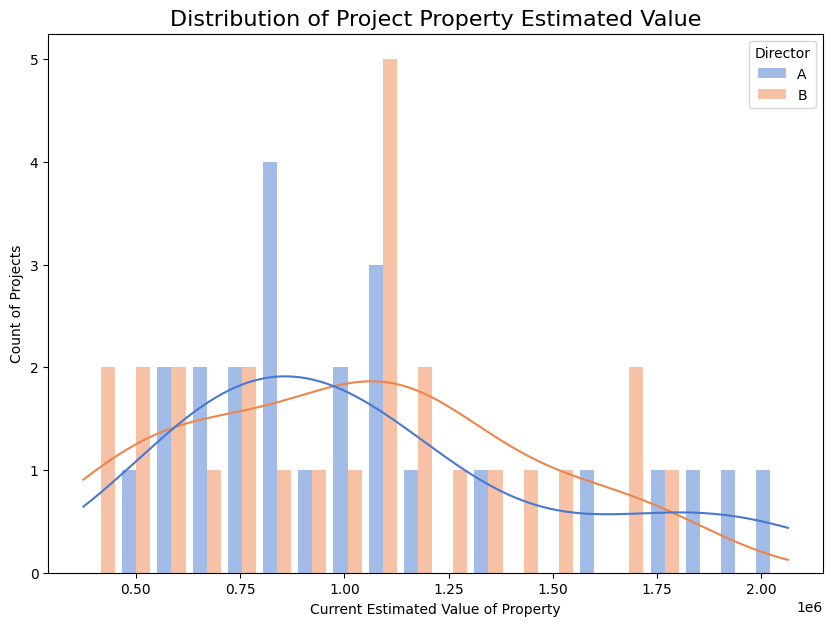

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.histplot(data=df, x="Current Est Value", bins=20, hue="Director", kde=True, multiple="dodge",
            shrink=.8, palette="muted", ec="None", ax=ax, hue_order=["A", "B"])

ax.set_title("Distribution of Project Property Estimated Value", fontsize=16)
ax.set_xlabel("Current Estimated Value of Property")
ax.set_ylabel("Count of Projects")
plt.show()

In [20]:
print("Average value of all projects:")
print(df.groupby("Director")["Current Est Value"].mean())

print("Median value of all projects:")
print(df.groupby("Director")["Current Est Value"].median())

Average value of all projects:
Director
A    1.072060e+06
B    1.015438e+06
Name: Current Est Value, dtype: float64
Median value of all projects:
Director
A     976616.0
B    1052142.5
Name: Current Est Value, dtype: float64


Previously I speculated on the reasons why Director A quotes for more hours for their projects. I suggested that it could be because they take on bigger / more valued projects, as then the clients for such projects are likely to be willing to spend more money on their renovation project.

Looking at the histogram and the average value of all projects, A and B have quite a similar range, with A's amount of higher end projects to be slightly higher. However, B's project property values has a higher median, and the kde curve looks like the distribution is slightly shifted towards the right (the more expensive end). Therefore A and B's project property values are actually not too dissimilar, and the difference isn't significant enough.

**This then indicates and confirms that Director B is likely to under-quote more.** 

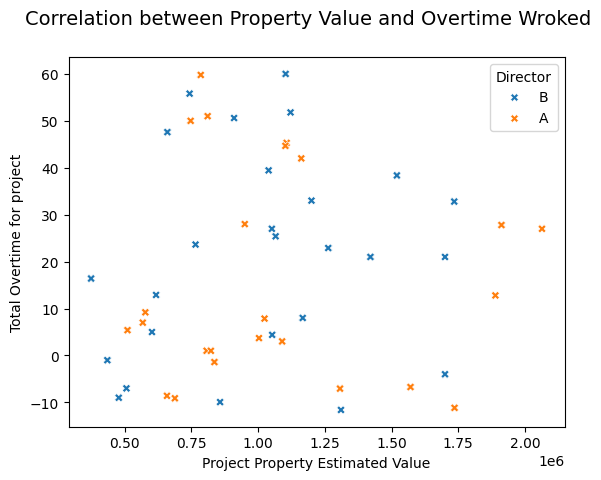

In [21]:
# Exploring to see if there's a correlation between the house value and the amount of overtime worked
sns.scatterplot(df, x="Current Est Value", y="Total OT", hue="Director", marker="X")
plt.xlabel("Project Property Estimated Value")
plt.ylabel("Total Overtime for project")
plt.suptitle("Correlation between Property Value and Overtime Wroked", fontsize = 14)
plt.show()

Previously, I assumed that there might be some correlation between property value and overtime worked, i.e. the bigger projects (more expensive properties) will end up having more work needed, therefore requiring more than than planned and resulting in overtime.

To my surprise, the scatter plot above does not really show a obvious correlation, or if any correlation at all, as the points almost look like they are at random, as they are fairly evenly distributed across the axis.

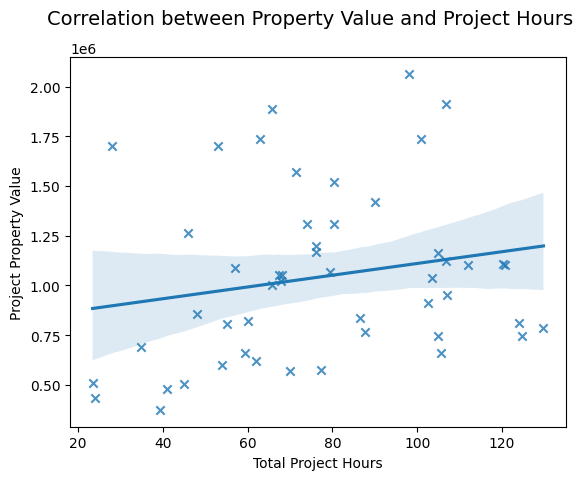

In [22]:
# Exploring to see if there's a correlation between the hours quoted by Directors and the property value
sns.regplot(df, x="Total Hours", y="Current Est Value", marker="x")
plt.xlabel("Total Project Hours")
plt.ylabel("Project Property Value")
plt.suptitle("Correlation between Property Value and Project Hours", fontsize = 14)
plt.show()

<Figure size 640x480 with 0 Axes>

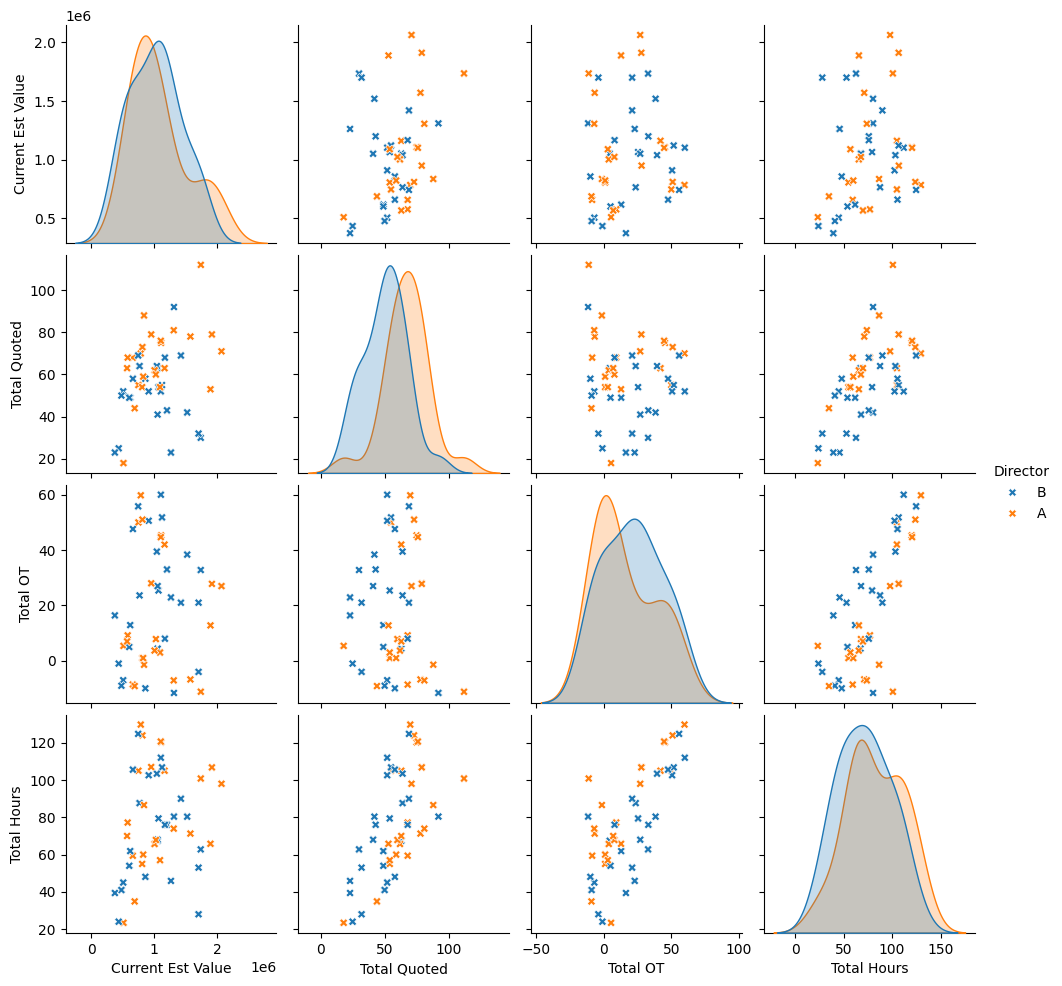

In [23]:
plt.figure()
sns.pairplot(df, vars=df.columns[11:].tolist(), markers="X", hue="Director")
plt.show()

The pairplot shows that the property value might have a slight positive correlation with hours quoted / total hours. But the hours quoted have a clear positive correlation with total hours, therefore the initial input of hours quoted is still relevant.

### Summary of Findings

1. The RIBA Stage will play a factor, as some stages are more severely under-quoted.

2. Director B is likely to under-quote more hours.

3. Director A's projects has issues with missing recordings in the dataset.

4. House price does not seem to have a correlation with overtime, but might do with overall time on a project.